In [1]:
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt
import scipy.io
from sklearn.datasets.base import Bunch
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

/Users/ouyang/opt/anaconda3/envs/python36/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


## [10 points] Download the ChEMBL database or setup queries to download a subset of the database. An already processed version of the dataset is available here (thanks to Niraj Verma): https://smu.box.com/s/smqmwlef0yehpieicwxqdr99k7f9ru04

In [2]:
f = open('./dataCHEMBL/data.csv', 'r', encoding="ISO-8859-1")
lines = f.readlines()
f.close()

In [3]:
len(lines)

1065321

In [4]:
flis = [] # will have [id, ic50_val, unit, target, smiles] 
for line in lines[:1]: # first line contains the headers (therefore skiped)
    lis = line.strip().split(',')
    if len(lis) < 36:
        continue
    print(line)
    print(len(lis))

" M o l e c u l e " , " S t a n d a r d   T y p e " , " S t a n d a r d   R e l a t i o n " , " S t a n d a r d   V a l u e " , " S t a n d a r d   U n i t s " , " p C h E M B L   V a l u e " , " C o m m e n t " , " C o m p o u n d   K e y " , " A s s a y " , " A s s a y   D e s c r i p t i o n " , " B A O   F o r m a t " , " T a r g e t " , " T a r g e t   P r e f .   N a m e " , " T a r g e t   O r g a n i s m " , " T a r g e t   T y p e " , " D o c u m e n t " , " S o u r c e " , " M a x   P h a s e " , " # R o 5   V i o l a t i o n s " , " M o l e c u l a r   W e i g h t " , " L i g a n d   E f f i c i e n c y   B E I " , " L i g a n d   E f f i c i e n c y   L E " , " L i g a n d   E f f i c i e n c y   L L E " , " L i g a n d   E f f i c i e n c y   S E I " , " A L o g P " , " A s s a y   O r g a n i s m " , " A s s a y   T i s s u e   C h E M B L   I D " , " A s s a y   T i s s u e   N a m e " , " A s s a y   C e l l   T y p e " , " A s s a y   S u b c e l l u l a r   F r a c t 

There are totally 43 columns for this dataset

In [5]:
for line in lines[1:]: # first line contains the headers (therefore skiped)
    lis = line.strip().split(',')
    if len(lis) != 43:
        print(line)
        print(len(lis))
        break

 " C H E M B L 3 5 7 3 3 8 " , " I C 5 0 " , " > " , " 5 0 0 0 0 " , " n M " , " " , " " , " 1 6   2 - g " , " C H E M B L 8 1 2 4 4 6 " , " I n h i b i t o r y   a c t i v i t y   a g a i n s t   T r y p a n o s o m a   c r u z i   t r y p a n o t h i o n e   d i s u l f i d e   r e d u c t a s e ,   a s s a y   i n   p r e s e n c e   o f   5 7   u M   T ( S ) 2 . " , " s i n g l e   p r o t e i n   f o r m a t " , " C H E M B L 5 1 3 1 " , " T r y p a n o t h i o n e   r e d u c t a s e " , " T r y p a n o s o m a   c r u z i " , " S I N G L E   P R O T E I N " , " C H E M B L 1 1 3 4 7 9 1 " , " S c i e n t i f i c   L i t e r a t u r e " , " 0 " , " 0 " , " 3 2 6 . 4 " , " " , " " , " " , " " , " 1 . 9 4 " , " T r y p a n o s o m a   c r u z i " , " " , " " , " " , " " , " 5 6 9 3 " , " B A O _ 0 0 0 0 3 5 7 " , " " , " " , " " , " " , " C N 1 C C N ( C C 1 ) C ( = O ) C C C 2 = C ( C ) C ( = O ) c 3 c c c c c 3 C 2 = O " , " " , " J .   M e d .   C h e m . " , " 2 0 0 1 " , " 1 "

In [6]:
bad_column_count = 0
for line in lines[1:]: # first line contains the headers (therefore skiped)
    lis = line.strip().split(',')
    if len(lis) != 43:
        bad_column_count += 1

bad_column_count

295467

Although we have more than 1 million lines of records, it will be a great lost if we throw away about 300k records.

We can see this sentence:

Inhibitory activity against Trypanosoma cruzi trypanothione disulfide reductase, assay in presence of 57 uM T(S)2.

which also contains a ',' inside. That's the reason the len(lis) is not 43 but 44 because we use ',' to split the whole line. Therefore, we need to use some other character to replace the ',' in the original lines and use that character to split.

We use '?' to replace ','.

In [7]:
# First get the column names
column_line = lines[0]
text = ''
for t in column_line:
    text += t
text = text.replace('\x00', '')
text = text.strip()
text = text.replace('"', '')

column_names = text.split(',')
print(column_names)
print(len(column_names))

print('\n')
print(column_names[0])
print(column_names[3])
print(column_names[4])
print(column_names[8])
print(column_names[36])

['Molecule', 'Standard Type', 'Standard Relation', 'Standard Value', 'Standard Units', 'pChEMBL Value', 'Comment', 'Compound Key', 'Assay', 'Assay Description', 'BAO Format', 'Target', 'Target Pref. Name', 'Target Organism', 'Target Type', 'Document', 'Source', 'Max Phase', '#Ro5 Violations', 'Molecular Weight', 'Ligand Efficiency BEI', 'Ligand Efficiency LE', 'Ligand Efficiency LLE', 'Ligand Efficiency SEI', 'ALogP', 'Assay Organism', 'Assay Tissue ChEMBL ID', 'Assay Tissue Name', 'Assay Cell Type', 'Assay Subcellular Fraction', 'Organism Tax ID', 'BAO Format ID', 'Published Type', 'Published Relation', 'Published Value', 'Published Units', 'Canonical Smiles', 'Data Validity Comment', 'Document Journal', 'Document Year', 'SRC ID', 'UO Units', 'Potential Duplicate']
43


Molecule
Standard Value
Standard Units
Assay
Canonical Smiles


In [8]:
# Then handle the rest of lines
for index, line in enumerate(lines[1:]):
    lis = line.strip().split(',')
    if len(lis) != 43:
        print(len(lis))
        print(index+1)
        break

44
6


For here, we found an example of one line that cause the error of '44' columns, which is at the 6th line.

In [9]:
bad_example = lines[6]
bad_example = bad_example.replace('\x00', '')
bad_example = bad_example.strip()
bad_example = bad_example.replace('","', '"?"')
bad_list = bad_example.replace('"', '')

bad_list = bad_list.split('?')
print(bad_list)
print(len(bad_list))

['CHEMBL357338', 'IC50', '>', '50000', 'nM', '', '', '16 2-g', 'CHEMBL812446', 'Inhibitory activity against Trypanosoma cruzi trypanothione disulfide reductase, assay in presence of 57 uM T(S)2.', 'single protein format', 'CHEMBL5131', 'Trypanothione reductase', 'Trypanosoma cruzi', 'SINGLE PROTEIN', 'CHEMBL1134791', 'Scientific Literature', '0', '0', '326.4', '', '', '', '', '1.94', 'Trypanosoma cruzi', '', '', '', '', '5693', 'BAO_0000357', '', '', '', '', 'CN1CCN(CC1)C(=O)CCC2=C(C)C(=O)c3ccccc3C2=O', '', 'J. Med. Chem.', '2001', '1', 'UO_0000065', 'False']
43


### The code below is running slow, can skip it

### -----------------

In [10]:
# After the testing above, the method works! 
# Then we can apply it to the whole lines of data

molecule = []
ic50_value = []
units = []
assay = []
smiles = []
bad_examples = []

for line in lines[1:]:
    text = ''
    for t in line:
        text += t
        
    text = text.replace('\x00', '')
    text = text.strip()
    text = text.replace('","', '"?"')
    text = text.replace('"', '')
    text = text.split('?')
    
    if len(text) != 43:
        bad_examples.append(text)
        continue
    
    if len(text) == 43:
        if text[3] != '':
            molecule.append(text[0])
            ic50_value.append(float(text[3]))
            units.append(text[4])
            assay.append(text[8])
            smiles.append(text[36])

print(len(ic50_value))

949755


In [11]:
data_dict = {'molecule':molecule, 'ic50':ic50_value, 'units':units, 'smiles':smiles, 'target':assay}
data = pd.DataFrame(data=data_dict)

In [12]:
data.to_csv('./data_all.csv')

In [13]:
data[:10]

,molecule,ic50,units,smiles,target
0,CHEMBL17430,11600.0,nM,Nc1nc(N)c2c(CSc3ccc(Cl)c(Cl)c3)c[nH]c2n1,CHEMBL664913
1,CHEMBL119370,9000.0,nM,NC(=S)\N=N\c1c(O)[nH]c2ccc(I)cc12,CHEMBL812106
2,CHEMBL239370,17900.0,nM,[Cl-].C[N+](C)(CCCN1c2ccccc2Sc3ccc(Cl)cc13)Cc4...,CHEMBL811877
3,CHEMBL61415,4200.0,nM,COc1cc(OC)cc(c1)N(C)Cc2c[nH]c3nc(N)nc(O)c23,CHEMBL664920
4,CHEMBL22,2700.0,nM,COc1cc(Cc2cnc(N)nc2N)cc(OC)c1OC,CHEMBL664913
5,CHEMBL357338,50000.0,nM,CN1CCN(CC1)C(=O)CCC2=C(C)C(=O)c3ccccc3C2=O,CHEMBL812446
6,CHEMBL116614,83.0,nM,Cc1c(CN(C=O)c2ccc(Cl)c(Cl)c2)cnc3nc(N)nc(N)c13,CHEMBL665696
7,CHEMBL119345,15000.0,nM,Cc1ccc2[nH]c(O)c(\N=N\C(=N)S)c2c1,CHEMBL805131
8,CHEMBL54399,20.0,nM,CN(Cc1ccc2nc(N)nc(N)c2n1)c3cccc(Cl)c3,CHEMBL665702
9,CHEMBL1673327,10000.0,nM,COC(OC)c1ccc(C#N)c(SCC(=O)c2ccc(Cl)cc2)n1,CHEMBL1677388


### ---------------------------

## [10 points] Filter the database to the top 100 targets in the database. You will need a definition of "top" such as the targets with the most assays. From these top 100 targets, save the ligands that have an assay result for each of the targets. 

In [38]:
data = pd.read_csv('./data_all.csv')
data = data.drop(columns=[data.columns[0]], axis=1)
data.head()

,molecule,ic50,units,smiles,target
0,CHEMBL17430,11600.0,nM,Nc1nc(N)c2c(CSc3ccc(Cl)c(Cl)c3)c[nH]c2n1,CHEMBL664913
1,CHEMBL119370,9000.0,nM,NC(=S)\N=N\c1c(O)[nH]c2ccc(I)cc12,CHEMBL812106
2,CHEMBL239370,17900.0,nM,[Cl-].C[N+](C)(CCCN1c2ccccc2Sc3ccc(Cl)cc13)Cc4...,CHEMBL811877
3,CHEMBL61415,4200.0,nM,COc1cc(OC)cc(c1)N(C)Cc2c[nH]c3nc(N)nc(O)c23,CHEMBL664920
4,CHEMBL22,2700.0,nM,COc1cc(Cc2cnc(N)nc2N)cc(OC)c1OC,CHEMBL664913


In [39]:
data['target'].value_counts()

CHEMBL2114881    2057
CHEMBL2114714    1381
CHEMBL1738239    1210
CHEMBL1614190    1205
CHEMBL1963941    1186
                 ... 
CHEMBL3761681       1
CHEMBL2184774       1
CHEMBL1262357       1
CHEMBL4005779       1
CHEMBL3744272       1
Name: target, Length: 77472, dtype: int64

In [40]:
# At first we tried get top 100 targets, but there are not enough data after preprocessing
# get top 500 targets with the most assay frequency
top500_count = data['target'].value_counts()[:500]
index_top500 = top500_count.index
index_top500[:3]

Index(['CHEMBL2114881', 'CHEMBL2114714', 'CHEMBL1738239'], dtype='object')

In [41]:
data_top500 = data[data['target'].isin(index_top500)]
data_top500.head()

,molecule,ic50,units,smiles,target
78,CHEMBL278261,870.00,nM,CN(Cc1c[nH]c2nc(N)nc(N)c12)c3cccc4ccccc34,CHEMBL828662
79,CHEMBL142081,57.94,nM,COc1ccccc1Sc2ccc3nc(N)nc(N)c3n2,CHEMBL830839
80,CHEMBL121319,97.00,nM,Nc1nc(N)c2CC(CNc3cc(Cl)ccc3Cl)CCc2n1,CHEMBL828662
81,CHEMBL121319,97.01,nM,Nc1nc(N)c2CC(CNc3cc(Cl)ccc3Cl)CCc2n1,CHEMBL830839
83,CHEMBL299174,14.00,nM,COc1ccc(N(C)Cc2ccc3nc(N)nc(N)c3n2)c(OC)c1,CHEMBL828662


In [42]:
# data_top500.to_csv('./df_top500.csv')

### Read the saved file can save some time

In [45]:
data_top500 = pd.read_csv('./df_top500.csv')
data_top500 = data_top500.drop(columns=[data_top500.columns[0]], axis=1)
data_top500.head()

,molecule,ic50,units,smiles,target
0,CHEMBL278261,870.00,nM,CN(Cc1c[nH]c2nc(N)nc(N)c12)c3cccc4ccccc34,CHEMBL828662
1,CHEMBL142081,57.94,nM,COc1ccccc1Sc2ccc3nc(N)nc(N)c3n2,CHEMBL830839
2,CHEMBL121319,97.00,nM,Nc1nc(N)c2CC(CNc3cc(Cl)ccc3Cl)CCc2n1,CHEMBL828662
3,CHEMBL121319,97.01,nM,Nc1nc(N)c2CC(CNc3cc(Cl)ccc3Cl)CCc2n1,CHEMBL830839
4,CHEMBL299174,14.00,nM,COc1ccc(N(C)Cc2ccc3nc(N)nc(N)c3n2)c(OC)c1,CHEMBL828662


In [46]:
# check dirty data and drop it
dropped_data = data_top500.copy()
print(dropped_data.isna().sum(), '\n')
print("The length of data before dropping dirty data: ", len(dropped_data))
dropped_data = dropped_data.dropna()
print("The length of data after dropping dirty data: ", len(dropped_data))

molecule      0
ic50          0
units         0
smiles      352
target        0
dtype: int64 

The length of data before dropping dirty data:  176752
The length of data after dropping dirty data:  176400


## [5 points] Binarize the binding affinity for each ligand in the assay. That is, convert the continuous measure of binding to binary. You should use the column 'IC50' for this calculation. Anything below 300 nM should be considered as an active binding. Anything above 10 uM should be considered non-binding (inactive). 

In [47]:
# make sure the unit are all nM
data_top500_dropped = dropped_data.copy()
nm_count = data_top500_dropped['units'].value_counts()
nm_count

nM    176400
Name: units, dtype: int64

In [48]:
# We first need to filter out the records with ic50 value less than 300 uM or bigger than 10000 uM
df = data_top500_dropped.copy()
print("Rows before dropping: {}".format(len(df)))
drop_index = df[((df.ic50>300) & (df.ic50<10000))].index
df.drop(drop_index)
print("Rows after dropping: {}".format(len(df)))

Rows before dropping: 176400
Rows after dropping: 176400


In [49]:
# Binarize the binding affinity
# 1 - active, 0 - inactive
df['active'] = np.where(df.ic50<=300, 1, 0)
print("Dataset length: ", len(df))
print(df['active'].value_counts())
df.iloc[:5]

Dataset length:  176400
0    105940
1     70460
Name: active, dtype: int64


,molecule,ic50,units,smiles,target,active
0,CHEMBL278261,870.00,nM,CN(Cc1c[nH]c2nc(N)nc(N)c12)c3cccc4ccccc34,CHEMBL828662,0
1,CHEMBL142081,57.94,nM,COc1ccccc1Sc2ccc3nc(N)nc(N)c3n2,CHEMBL830839,1
2,CHEMBL121319,97.00,nM,Nc1nc(N)c2CC(CNc3cc(Cl)ccc3Cl)CCc2n1,CHEMBL828662,1
3,CHEMBL121319,97.01,nM,Nc1nc(N)c2CC(CNc3cc(Cl)ccc3Cl)CCc2n1,CHEMBL830839,1
4,CHEMBL299174,14.00,nM,COc1ccc(N(C)Cc2ccc3nc(N)nc(N)c3n2)c(OC)c1,CHEMBL828662,1


In [65]:
type(df['active'].iloc[0])

numpy.int64

In [67]:
# There might be some targets whose 'active' list are all ones or zeros
# or the ratio of ones or zeros are too small
# Which is imbalanced and do harm to learning process
# We need to get rid of these data
df_balance = df.copy()

counts_dict = dict()
for key in index_top500:
    counts_dict[key] = {'1':0, '0':0, 'ratio':0}
    
for i in range(len(df_balance)):
    if df_balance['active'].iloc[i] == 1:
        counts_dict[df_balance['target'].iloc[i]]['1'] += 1
    else:
        counts_dict[df_balance['target'].iloc[i]]['0'] += 1

for key in counts_dict.keys():
    counts_dict[key]['ratio'] = counts_dict[key]['1'] / (counts_dict[key]['1']+counts_dict[key]['0'])

In [113]:
for key in counts_dict.keys():
    print(counts_dict[key]['ratio'])

0.0
0.0
0.0
0.0008361204013377926
0.0
0.0
0.0
0.0
0.8888888888888888
0.47984267453294
0.0009900990099009901
0.0
0.0
0.00791295746785361
0.009891196834817012
0.0010111223458038423
0.0425531914893617
0.047872340425531915
0.012276785714285714
0.0
0.9
0.76375
0.017676767676767676
0.017676767676767676
0.017676767676767676
0.6394293125810635
0.7559366754617414
0.7683089214380826
0.0
0.902834008097166
0.5800273597811217
0.8248275862068966
0.0
0.0014204545454545455
0.0
0.0014204545454545455
0.9957142857142857
0.002881844380403458
0.4676470588235294
0.0
0.7421289355322339
0.9775112443778111
0.26957831325301207
0.9547511312217195
0.96
0.02157164869029276
0.0077279752704791345
0.03400309119010819
0.00463678516228748
0.017001545595054096
0.00463678516228748
0.5170278637770898
1.0
0.009448818897637795
0.5889763779527559
0.7381703470031545
0.0
0.8676236044657097
0.9552715654952076
0.9598715890850722
0.025682182985553772
0.7207062600321027
0.0016129032258064516
0.9549114331723028
0.0
0.0
0.7550335570

In [116]:
filtered_index = list(index_top500.copy())

print('Before removing imbalanced data, target amounts are: ',len(filtered_index))

for key in counts_dict.keys():
    if (counts_dict[key]['ratio'] < 0.3) or (counts_dict[key]['ratio'] > 0.8):
        filtered_index.remove(key)

print('After removing imbalanced data, target amounts are: ',len(filtered_index))

Before removing imbalanced data, target amounts are:  500
After removing imbalanced data, target amounts are:  134


In [117]:
df_filter_balance = df_balance[df_balance['target'].isin(filtered_index)]
print(df_filter_balance.shape)
df_filter_balance.head()

(44923, 6)


,molecule,ic50,units,smiles,target,active
0,CHEMBL278261,870.00,nM,CN(Cc1c[nH]c2nc(N)nc(N)c12)c3cccc4ccccc34,CHEMBL828662,0
1,CHEMBL142081,57.94,nM,COc1ccccc1Sc2ccc3nc(N)nc(N)c3n2,CHEMBL830839,1
2,CHEMBL121319,97.00,nM,Nc1nc(N)c2CC(CNc3cc(Cl)ccc3Cl)CCc2n1,CHEMBL828662,1
3,CHEMBL121319,97.01,nM,Nc1nc(N)c2CC(CNc3cc(Cl)ccc3Cl)CCc2n1,CHEMBL830839,1
4,CHEMBL299174,14.00,nM,COc1ccc(N(C)Cc2ccc3nc(N)nc(N)c3n2)c(OC)c1,CHEMBL828662,1


## [10 points] Featurize each ligand using RDKit (https://www.rdkit.org (Links to an external site.)). This will convert the ligand representation into a binary vector of features. Mention any hyper parameters you use.

In [118]:
from rdkit import Chem
from rdkit.Chem import AllChem
import rdkit
from rdkit.Chem.AtomPairs import Pairs

In [119]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

/Users/ouyang/opt/anaconda3/envs/python36/bin/python
3.6.10 |Anaconda, Inc.| (default, Mar 23 2020, 17:45:12) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
sys.version_info(major=3, minor=6, micro=10, releaselevel='final', serial=0)


In [120]:
m1 = Chem.MolFromSmiles(df['smiles'].iloc[0])
m2 = Chem.MolFromSmiles(df['smiles'].iloc[1])
m3 = Chem.MolFromSmiles(df['smiles'].iloc[2])
m4 = Chem.MolFromSmiles(df['smiles'].iloc[3])
m5 = Chem.MolFromSmiles(df['smiles'].iloc[4])
mols = [m1, m2, m3, m4, m5]

In [121]:
# refer: https://www.rdkit.org/docs/Cookbook.html
# generate fingeprints: Morgan fingerprint with radius 2
fps = [AllChem.GetMorganFingerprintAsBitVect(m, 2) for m in mols]
# convert the RDKit explicit vectors into numpy arrays
np_fps = np.asarray(fps)

print(np_fps)
print(np_fps.shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(5, 2048)


In [122]:
# the default bits are 2048, we can make it to 512
# but we still don't know how the bits number will impact the result
m = AllChem.GetMorganFingerprintAsBitVect(m1, radius=2, nBits=512)
bits = m.ToBitString()
print(bits)

00000000000000010000000000000000010001000010100000000000000010011000000000000100100000000010000001000000000000000000000000000000100000000001000000010000000000000000000000000001000000000000000000000000000000000000001010000000000000000000000000000000000000000000000000001000000000000000000000000010000000000000000000000001010001000000010001100001100000000000100000001000010000000010000000000000000000000001000001000010000000000100000001010000000000001000000000000000000000000000000000100000000000000000000000010000


In [123]:
m = Pairs.GetAtomPairFingerprintAsBitVect(m1)
print(len(m.ToBitString()))

8388608


The result of *Pairs.GetAtomPairFingerprintAsBitVect(m1)* is too too big... And we have no idea about what this result means. So we don't use it.

In [124]:
m = AllChem.GetHashedAtomPairFingerprintAsBitVect(m1, nBits=512)
print(m.ToBitString())
print()

10000000000000001100110011101000000011000000111000000000111000001110100011100000111010001110110000001110000010000000000011101000000011000000000011000000111011000000100000000000100010001000111011110000111010000000000000001110111111000000000011101111111011111000110000000000100011000000111011100000110010000000000000000000111011101100111100001000110011001100000011000000100000001000100011000000110000001100110011001110100000001000100010001000000011000000111111001110100000001110000010001110100000001110110011111110



The GetMorganFingerprintAsBitVect( ) and GetHashedAtomPairFingerprintAsBitVect( ) look great and might be helpful to the learning task.

In [125]:
print(rdkit.__version__)

2019.09.3


### For this part, we are going to use MorganFingerprint as feature and ic50 as classification task. And the AtomFingerprint will be used in the exceptional part

In [126]:
# convert smiles to MorganFingerprint np array
def smilesToMorganFingerprint_asarray(smile, nBits=512):
    try:
        mol = Chem.MolFromSmiles(smile)
        m = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=nBits)
    except ValueError:
        print("Can't get MorganFingerPrint becauses of some errors: ", smile)
    
    bits = m.ToBitString()
    return np.asarray([int(i) for i in m])

# convert smiles to AtomFingerprint np array
def smilesToAtomFingerprint_asarray(smile, nBits=512):
    try:
        mol = Chem.MolFromSmiles(smile)
        m = AllChem.GetHashedAtomPairFingerprintAsBitVect(mol=mol, nBits=nBits)
    except ValueError:
        print("Can't get MorganFingerPrint becauses of some errors: ", smile)
    
    bits = m.ToBitString()
    return np.asarray([int(i) for i in m])

In [127]:
print(len(smilesToMorganFingerprint_asarray(df_filter_balance['smiles'].iloc[0], 512)))
print(len(smilesToAtomFingerprint_asarray(df_filter_balance['smiles'].iloc[0], 512)))

512
512


In [128]:
df_filter_balance.head()

,molecule,ic50,units,smiles,target,active
0,CHEMBL278261,870.00,nM,CN(Cc1c[nH]c2nc(N)nc(N)c12)c3cccc4ccccc34,CHEMBL828662,0
1,CHEMBL142081,57.94,nM,COc1ccccc1Sc2ccc3nc(N)nc(N)c3n2,CHEMBL830839,1
2,CHEMBL121319,97.00,nM,Nc1nc(N)c2CC(CNc3cc(Cl)ccc3Cl)CCc2n1,CHEMBL828662,1
3,CHEMBL121319,97.01,nM,Nc1nc(N)c2CC(CNc3cc(Cl)ccc3Cl)CCc2n1,CHEMBL830839,1
4,CHEMBL299174,14.00,nM,COc1ccc(N(C)Cc2ccc3nc(N)nc(N)c3n2)c(OC)c1,CHEMBL828662,1


In [129]:
df_filter_balance['active'].value_counts()

1    27334
0    17589
Name: active, dtype: int64

The 0 and 1 proportion is quite normal.

In [130]:
# prepare and initialize data before training model
# df_filter_balance is the already filtered-data with filtered-top500 target
tasks = dict()
for single_target in df_filter_balance['target']:
    # tasks[single_target][0]: MorganFingerPrint
    # tasks[single_target][1]: AtomFingerPrint
    # tasks[single_target][2]: df_filter_balance['active'], which is the predicted target
    tasks[single_target] = [[], [], []]
    
# put data into the dictionary    
for i in range(len(df_filter_balance)):
    mf_array = smilesToMorganFingerprint_asarray(df_filter_balance.iloc[i]['smiles'])
    af_array = smilesToAtomFingerprint_asarray(df_filter_balance.iloc[i]['smiles'])
    active_value = df_filter_balance.iloc[i]['active']
    key = df_filter_balance.iloc[i]['target']
    tasks[key][0].append(mf_array)
    tasks[key][1].append(af_array)
    tasks[key][2].append(active_value)

# convert data to numpy array for training preparation
for key in tasks.keys():
    tasks[key][0] = np.array(tasks[key][0])
    tasks[key][1] = np.array(tasks[key][1])
    tasks[key][2] = np.array(tasks[key][2])

In [131]:
print(tasks.keys())

dict_keys(['CHEMBL828662', 'CHEMBL830839', 'CHEMBL1243974', 'CHEMBL1243972', 'CHEMBL763870', 'CHEMBL830838', 'CHEMBL830957', 'CHEMBL830842', 'CHEMBL829401', 'CHEMBL1119333', 'CHEMBL1006579', 'CHEMBL3431932', 'CHEMBL2038596', 'CHEMBL2038597', 'CHEMBL1243970', 'CHEMBL1243973', 'CHEMBL1243967', 'CHEMBL3706327', 'CHEMBL3707962', 'CHEMBL3707950', 'CHEMBL3705261', 'CHEMBL3707951', 'CHEMBL3707783', 'CHEMBL3705917', 'CHEMBL3706272', 'CHEMBL3888429', 'CHEMBL3888209', 'CHEMBL3888181', 'CHEMBL3888461', 'CHEMBL3888103', 'CHEMBL3887033', 'CHEMBL3705790', 'CHEMBL3706356', 'CHEMBL3705585', 'CHEMBL3705357', 'CHEMBL3706088', 'CHEMBL3705047', 'CHEMBL3705123', 'CHEMBL3706152', 'CHEMBL3705844', 'CHEMBL3705282', 'CHEMBL3705869', 'CHEMBL3705924', 'CHEMBL3705963', 'CHEMBL3705791', 'CHEMBL3887679', 'CHEMBL3887886', 'CHEMBL3888194', 'CHEMBL3705927', 'CHEMBL3887812', 'CHEMBL3887759', 'CHEMBL3705698', 'CHEMBL3705827', 'CHEMBL2328568', 'CHEMBL3888178', 'CHEMBL3706306', 'CHEMBL3887700', 'CHEMBL3887866', 'CHEMBL388

In [132]:
# some statistic data for the task
print("task, MorganFingerprint.shape, AtomFingerprint.shape, active_value.shape:")
for index, item in enumerate(tasks.items()):
    print(item[0], item[1][0].shape, item[1][1].shape, item[1][2].shape)
    if index == 10:
        break

task, MorganFingerprint.shape, AtomFingerprint.shape, active_value.shape:
CHEMBL828662 (177, 512) (177, 512) (177,)
CHEMBL830839 (177, 512) (177, 512) (177,)
CHEMBL1243974 (171, 512) (171, 512) (171,)
CHEMBL1243972 (171, 512) (171, 512) (171,)
CHEMBL763870 (305, 512) (305, 512) (305,)
CHEMBL830838 (177, 512) (177, 512) (177,)
CHEMBL830957 (177, 512) (177, 512) (177,)
CHEMBL830842 (177, 512) (177, 512) (177,)
CHEMBL829401 (177, 512) (177, 512) (177,)
CHEMBL1119333 (417, 512) (417, 512) (417,)
CHEMBL1006579 (338, 512) (338, 512) (338,)


## Multi-task Model

## [20 points] Train a multi-task model (one model for each target). Use an 80/20 split for each target.

In [133]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import tensorflow as tf
from sklearn.model_selection import train_test_split

X_train = dict()
y_train = dict()
X_test = dict()
y_test = dict()

for x in tasks.keys():
    X_train[x], X_test[x], y_train[x], y_test[x] = train_test_split(tasks[x][0],
                                                   tasks[x][2],
                                                   test_size=0.2, random_state=42)
        

In [134]:
inputs = Input(shape=(512,))
shared_mlp = Dense(64, activation='relu')(inputs)
shared_mlp = Dense(64, activation='relu')(shared_mlp)

# make a dictionary of models for each task
models_mtl = dict()

for x in tasks.keys():
    personal_layer = Dense(10, activation='relu')(shared_mlp)
    output_layer = Dense(1, activation='sigmoid')(personal_layer)
    model = Model(inputs=inputs, outputs=output_layer)
    model.compile(optimizer='sgd', loss='binary_crossentropy')
    models_mtl[x] = model

In [135]:
models_mtl['CHEMBL828662'].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 512)               0         
_________________________________________________________________
dense_744 (Dense)            (None, 64)                32832     
_________________________________________________________________
dense_745 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_746 (Dense)            (None, 10)                650       
_________________________________________________________________
dense_747 (Dense)            (None, 1)                 11        
Total params: 37,653
Trainable params: 37,653
Non-trainable params: 0
_________________________________________________________________


In [136]:
%%time
from tqdm import tqdm

EPOCHS = 2
from random import shuffle

all_keys = list(tasks.keys())

for i in range(EPOCHS):
    print('Epoch ', i)
    for x in tqdm(all_keys):
        models_mtl[x].fit(X_train[x], y_train[x], verbose=1)

  0%|          | 0/134 [00:00<?, ?it/s]

Epoch  0
Epoch 1/1
141/141 [==============================] - 19s 135ms/step - loss: 0.7484


  1%|          | 1/134 [00:19<43:49, 19.77s/it]

Epoch 1/1
141/141 [==============================] - 7s 51ms/step - loss: 0.6704


  1%|▏         | 2/134 [00:27<35:38, 16.20s/it]

Epoch 1/1
136/136 [==============================] - 7s 53ms/step - loss: 0.7033


  2%|▏         | 3/134 [00:35<29:57, 13.72s/it]

Epoch 1/1
136/136 [==============================] - 7s 53ms/step - loss: 0.6968


  3%|▎         | 4/134 [00:43<25:59, 11.99s/it]

Epoch 1/1
244/244 [==============================] - 7s 30ms/step - loss: 0.7281


  4%|▎         | 5/134 [00:51<23:17, 10.84s/it]

Epoch 1/1
141/141 [==============================] - 7s 51ms/step - loss: 0.6990


  4%|▍         | 6/134 [00:59<21:17,  9.98s/it]

Epoch 1/1
141/141 [==============================] - 7s 53ms/step - loss: 0.7542


  5%|▌         | 7/134 [01:07<19:59,  9.45s/it]

Epoch 1/1
141/141 [==============================] - 7s 52ms/step - loss: 0.7049


  6%|▌         | 8/134 [01:16<19:02,  9.07s/it]

Epoch 1/1
141/141 [==============================] - 7s 53ms/step - loss: 0.7070


  7%|▋         | 9/134 [01:24<18:24,  8.83s/it]

Epoch 1/1
333/333 [==============================] - 7s 23ms/step - loss: 0.7147


  7%|▋         | 10/134 [01:32<17:56,  8.68s/it]

Epoch 1/1
270/270 [==============================] - 8s 28ms/step - loss: 0.6341


  8%|▊         | 11/134 [01:41<17:37,  8.60s/it]

Epoch 1/1
367/367 [==============================] - 8s 21ms/step - loss: 0.6270


  9%|▉         | 12/134 [01:49<17:20,  8.53s/it]

Epoch 1/1
166/166 [==============================] - 8s 46ms/step - loss: 0.7549


 10%|▉         | 13/134 [01:57<17:09,  8.51s/it]

Epoch 1/1
166/166 [==============================] - 8s 47ms/step - loss: 0.7042


 10%|█         | 14/134 [02:06<17:06,  8.55s/it]

Epoch 1/1
166/166 [==============================] - 8s 46ms/step - loss: 0.6895


 11%|█         | 15/134 [02:15<17:03,  8.60s/it]

Epoch 1/1
137/137 [==============================] - 8s 56ms/step - loss: 0.7132


 12%|█▏        | 16/134 [02:23<16:54,  8.60s/it]

Epoch 1/1
167/167 [==============================] - 8s 46ms/step - loss: 0.7673


 13%|█▎        | 17/134 [02:32<16:45,  8.59s/it]

Epoch 1/1
507/507 [==============================] - 8s 15ms/step - loss: 0.6883


 13%|█▎        | 18/134 [02:41<16:43,  8.65s/it]

Epoch 1/1
276/276 [==============================] - 8s 28ms/step - loss: 0.6223


 14%|█▍        | 19/134 [02:49<16:39,  8.69s/it]

Epoch 1/1
290/290 [==============================] - 8s 27ms/step - loss: 0.6507


 15%|█▍        | 20/134 [02:58<16:35,  8.73s/it]

Epoch 1/1
206/206 [==============================] - 8s 38ms/step - loss: 0.6338


 16%|█▌        | 21/134 [03:07<16:30,  8.77s/it]

Epoch 1/1
254/254 [==============================] - 8s 31ms/step - loss: 0.6867


 16%|█▋        | 22/134 [03:16<16:26,  8.81s/it]

Epoch 1/1
129/129 [==============================] - 8s 63ms/step - loss: 0.6608


 17%|█▋        | 23/134 [03:25<16:25,  8.88s/it]

Epoch 1/1
166/166 [==============================] - 8s 49ms/step - loss: 0.7422


 18%|█▊        | 24/134 [03:34<16:22,  8.93s/it]

Epoch 1/1
146/146 [==============================] - 8s 55ms/step - loss: 0.6895


 19%|█▊        | 25/134 [03:43<16:14,  8.94s/it]

Epoch 1/1
533/533 [==============================] - 8s 15ms/step - loss: 0.6125


 19%|█▉        | 26/134 [03:52<16:12,  9.00s/it]

Epoch 1/1
298/298 [==============================] - 9s 30ms/step - loss: 0.7147


 20%|██        | 27/134 [04:02<16:37,  9.33s/it]

Epoch 1/1
175/175 [==============================] - 8s 45ms/step - loss: 0.7858


 21%|██        | 28/134 [04:11<16:17,  9.22s/it]

Epoch 1/1
144/144 [==============================] - 8s 57ms/step - loss: 0.6906


 22%|██▏       | 29/134 [04:21<16:06,  9.20s/it]

Epoch 1/1
146/146 [==============================] - 8s 56ms/step - loss: 0.6808


 22%|██▏       | 30/134 [04:30<15:56,  9.20s/it]

Epoch 1/1
408/408 [==============================] - 8s 20ms/step - loss: 0.6905


 23%|██▎       | 31/134 [04:39<15:48,  9.21s/it]

Epoch 1/1
392/392 [==============================] - 9s 23ms/step - loss: 0.7261


 24%|██▍       | 32/134 [04:49<16:02,  9.44s/it]

Epoch 1/1
252/252 [==============================] - 8s 33ms/step - loss: 0.6807


 25%|██▍       | 33/134 [04:58<15:54,  9.45s/it]

Epoch 1/1
148/148 [==============================] - 8s 56ms/step - loss: 0.7367


 25%|██▌       | 34/134 [05:08<15:45,  9.45s/it]

Epoch 1/1
471/471 [==============================] - 8s 18ms/step - loss: 0.7091


 26%|██▌       | 35/134 [05:17<15:39,  9.49s/it]

Epoch 1/1
476/476 [==============================] - 9s 18ms/step - loss: 0.6117


 27%|██▋       | 36/134 [05:27<15:35,  9.55s/it]

Epoch 1/1
231/231 [==============================] - 8s 36ms/step - loss: 0.6659


 28%|██▊       | 37/134 [05:37<15:26,  9.55s/it]

Epoch 1/1
600/600 [==============================] - 9s 14ms/step - loss: 0.6155


 28%|██▊       | 38/134 [05:46<15:19,  9.58s/it]

Epoch 1/1
288/288 [==============================] - 8s 29ms/step - loss: 0.7846


 29%|██▉       | 39/134 [05:56<15:10,  9.58s/it]

Epoch 1/1
240/240 [==============================] - 9s 36ms/step - loss: 0.6701


 30%|██▉       | 40/134 [06:06<15:04,  9.62s/it]

Epoch 1/1
261/261 [==============================] - 9s 33ms/step - loss: 0.6956


 31%|███       | 41/134 [06:16<15:29,  9.99s/it]

Epoch 1/1
544/544 [==============================] - 9s 16ms/step - loss: 0.7278


 31%|███▏      | 42/134 [06:26<15:14,  9.94s/it]

Epoch 1/1
266/266 [==============================] - 9s 33ms/step - loss: 0.7237


 32%|███▏      | 43/134 [06:36<15:02,  9.92s/it]

Epoch 1/1
132/132 [==============================] - 9s 66ms/step - loss: 0.6837


 33%|███▎      | 44/134 [06:46<14:51,  9.90s/it]

Epoch 1/1
303/303 [==============================] - 9s 29ms/step - loss: 0.6927


 34%|███▎      | 45/134 [06:56<14:40,  9.90s/it]

Epoch 1/1
303/303 [==============================] - 9s 29ms/step - loss: 0.6389


 34%|███▍      | 46/134 [07:06<14:32,  9.92s/it]

Epoch 1/1
372/372 [==============================] - 9s 24ms/step - loss: 0.6841


 35%|███▌      | 47/134 [07:16<14:29, 10.00s/it]

Epoch 1/1
606/606 [==============================] - 9s 15ms/step - loss: 0.6978


 36%|███▌      | 48/134 [07:26<14:25, 10.07s/it]

Epoch 1/1
388/388 [==============================] - 9s 23ms/step - loss: 0.6572


 37%|███▋      | 49/134 [07:36<14:18, 10.10s/it]

Epoch 1/1
160/160 [==============================] - 9s 55ms/step - loss: 0.7014


 37%|███▋      | 50/134 [07:47<14:10, 10.12s/it]

Epoch 1/1
368/368 [==============================] - 9s 24ms/step - loss: 0.6775


 38%|███▊      | 51/134 [07:57<14:02, 10.15s/it]

Epoch 1/1
229/229 [==============================] - 9s 39ms/step - loss: 0.7244


 39%|███▉      | 52/134 [08:07<13:57, 10.21s/it]

Epoch 1/1
144/144 [==============================] - 9s 62ms/step - loss: 0.6125


 40%|███▉      | 53/134 [08:17<13:49, 10.24s/it]

Epoch 1/1
813/813 [==============================] - 9s 11ms/step - loss: 0.6557


 40%|████      | 54/134 [08:28<13:44, 10.31s/it]

Epoch 1/1
192/192 [==============================] - 9s 49ms/step - loss: 0.6333


 41%|████      | 55/134 [08:39<13:46, 10.46s/it]

Epoch 1/1
194/194 [==============================] - 9s 48ms/step - loss: 0.6982


 42%|████▏     | 56/134 [08:49<13:41, 10.53s/it]

Epoch 1/1
144/144 [==============================] - 9s 64ms/step - loss: 0.6367


 43%|████▎     | 57/134 [09:00<13:31, 10.54s/it]

Epoch 1/1
244/244 [==============================] - 9s 38ms/step - loss: 0.6674


 43%|████▎     | 58/134 [09:11<13:24, 10.59s/it]

Epoch 1/1
412/412 [==============================] - 9s 23ms/step - loss: 0.6892


 44%|████▍     | 59/134 [09:21<13:17, 10.64s/it]

Epoch 1/1
182/182 [==============================] - 9s 51ms/step - loss: 0.6307


 45%|████▍     | 60/134 [09:32<13:07, 10.64s/it]

Epoch 1/1
168/168 [==============================] - 10s 60ms/step - loss: 0.6975


 46%|████▌     | 61/134 [09:44<13:15, 10.90s/it]

Epoch 1/1
238/238 [==============================] - 9s 39ms/step - loss: 0.6428


 46%|████▋     | 62/134 [09:55<13:07, 10.94s/it]

Epoch 1/1
184/184 [==============================] - 9s 51ms/step - loss: 0.7776


 47%|████▋     | 63/134 [10:05<12:54, 10.91s/it]

Epoch 1/1
380/380 [==============================] - 9s 25ms/step - loss: 0.6844


 48%|████▊     | 64/134 [10:16<12:43, 10.91s/it]

Epoch 1/1
584/584 [==============================] - 9s 16ms/step - loss: 0.6866


 49%|████▊     | 65/134 [10:27<12:34, 10.93s/it]

Epoch 1/1
148/148 [==============================] - 9s 64ms/step - loss: 0.7185


 49%|████▉     | 66/134 [10:38<12:24, 10.94s/it]

Epoch 1/1
233/233 [==============================] - 10s 42ms/step - loss: 0.6663


 50%|█████     | 67/134 [10:50<12:17, 11.01s/it]

Epoch 1/1
136/136 [==============================] - 9s 69ms/step - loss: 0.5445


 51%|█████     | 68/134 [11:00<12:05, 11.00s/it]

Epoch 1/1
284/284 [==============================] - 10s 34ms/step - loss: 0.6894


 51%|█████▏    | 69/134 [11:12<11:56, 11.03s/it]

Epoch 1/1
372/372 [==============================] - 10s 26ms/step - loss: 0.6292


 52%|█████▏    | 70/134 [11:23<11:47, 11.06s/it]

Epoch 1/1
176/176 [==============================] - 10s 55ms/step - loss: 0.6941


 53%|█████▎    | 71/134 [11:34<11:38, 11.09s/it]

Epoch 1/1
338/338 [==============================] - 10s 28ms/step - loss: 0.6807


 54%|█████▎    | 72/134 [11:45<11:29, 11.12s/it]

Epoch 1/1
143/143 [==============================] - 10s 67ms/step - loss: 0.7126


 54%|█████▍    | 73/134 [11:56<11:18, 11.13s/it]

Epoch 1/1
260/260 [==============================] - 10s 37ms/step - loss: 0.7046


 55%|█████▌    | 74/134 [12:08<11:11, 11.19s/it]

Epoch 1/1
132/132 [==============================] - 10s 74ms/step - loss: 0.7273


 56%|█████▌    | 75/134 [12:19<11:04, 11.26s/it]

Epoch 1/1
162/162 [==============================] - 10s 60ms/step - loss: 0.8262


 57%|█████▋    | 76/134 [12:30<10:55, 11.30s/it]

Epoch 1/1
359/359 [==============================] - 10s 27ms/step - loss: 0.6468


 57%|█████▋    | 77/134 [12:42<10:45, 11.32s/it]

Epoch 1/1
138/138 [==============================] - 10s 71ms/step - loss: 0.6756


 58%|█████▊    | 78/134 [12:53<10:36, 11.36s/it]

Epoch 1/1
138/138 [==============================] - 10s 72ms/step - loss: 0.7153


 59%|█████▉    | 79/134 [13:05<10:28, 11.42s/it]

Epoch 1/1
212/212 [==============================] - 10s 46ms/step - loss: 0.6873


 60%|█████▉    | 80/134 [13:16<10:18, 11.45s/it]

Epoch 1/1
144/144 [==============================] - 10s 69ms/step - loss: 0.7001


 60%|██████    | 81/134 [13:28<10:10, 11.51s/it]

Epoch 1/1
180/180 [==============================] - 10s 55ms/step - loss: 0.7424


 61%|██████    | 82/134 [13:40<10:01, 11.56s/it]

Epoch 1/1
404/404 [==============================] - 10s 25ms/step - loss: 0.6501


 62%|██████▏   | 83/134 [13:51<09:51, 11.60s/it]

Epoch 1/1
285/285 [==============================] - 10s 35ms/step - loss: 0.7169


 63%|██████▎   | 84/134 [14:03<09:41, 11.63s/it]

Epoch 1/1
466/466 [==============================] - 10s 21ms/step - loss: 0.7086


 63%|██████▎   | 85/134 [14:15<09:31, 11.66s/it]

Epoch 1/1
392/392 [==============================] - 10s 26ms/step - loss: 0.6856


 64%|██████▍   | 86/134 [14:27<09:22, 11.71s/it]

Epoch 1/1
233/233 [==============================] - 10s 43ms/step - loss: 0.6728


 65%|██████▍   | 87/134 [14:38<09:11, 11.73s/it]

Epoch 1/1
286/286 [==============================] - 11s 38ms/step - loss: 0.6641


 66%|██████▌   | 88/134 [14:51<09:11, 11.99s/it]

Epoch 1/1
616/616 [==============================] - 10s 17ms/step - loss: 0.6516


 66%|██████▋   | 89/134 [15:03<08:59, 11.99s/it]

Epoch 1/1
147/147 [==============================] - 10s 69ms/step - loss: 0.6786


 67%|██████▋   | 90/134 [15:15<08:47, 11.99s/it]

Epoch 1/1
321/321 [==============================] - 10s 32ms/step - loss: 0.5603


 68%|██████▊   | 91/134 [15:27<08:36, 12.00s/it]

Epoch 1/1
274/274 [==============================] - 10s 37ms/step - loss: 0.6656


 69%|██████▊   | 92/134 [15:39<08:24, 12.01s/it]

Epoch 1/1
132/132 [==============================] - 10s 77ms/step - loss: 0.6920


 69%|██████▉   | 93/134 [15:51<08:11, 12.00s/it]

Epoch 1/1
169/169 [==============================] - 10s 62ms/step - loss: 0.6944


 70%|███████   | 94/134 [16:03<08:06, 12.16s/it]

Epoch 1/1
159/159 [==============================] - 10s 64ms/step - loss: 0.6260


 71%|███████   | 95/134 [16:16<07:52, 12.13s/it]

Epoch 1/1
160/160 [==============================] - 10s 63ms/step - loss: 0.7127


 72%|███████▏  | 96/134 [16:28<07:38, 12.08s/it]

Epoch 1/1
404/404 [==============================] - 10s 25ms/step - loss: 0.7063


 72%|███████▏  | 97/134 [16:40<07:26, 12.08s/it]

Epoch 1/1
251/251 [==============================] - 10s 41ms/step - loss: 0.6882


 73%|███████▎  | 98/134 [16:52<07:15, 12.11s/it]

Epoch 1/1
168/168 [==============================] - 10s 61ms/step - loss: 0.5901


 74%|███████▍  | 99/134 [17:04<07:02, 12.07s/it]

Epoch 1/1
136/136 [==============================] - 10s 77ms/step - loss: 0.7160


 75%|███████▍  | 100/134 [17:16<06:52, 12.13s/it]

Epoch 1/1
192/192 [==============================] - 10s 53ms/step - loss: 0.6371


 75%|███████▌  | 101/134 [17:28<06:39, 12.10s/it]

Epoch 1/1
200/200 [==============================] - 10s 52ms/step - loss: 0.7254


 76%|███████▌  | 102/134 [17:40<06:29, 12.16s/it]

Epoch 1/1
260/260 [==============================] - 10s 40ms/step - loss: 0.7573


 77%|███████▋  | 103/134 [17:53<06:17, 12.18s/it]

Epoch 1/1
205/205 [==============================] - 10s 51ms/step - loss: 0.7367


 78%|███████▊  | 104/134 [18:05<06:08, 12.27s/it]

Epoch 1/1
421/421 [==============================] - 10s 25ms/step - loss: 0.6961


 78%|███████▊  | 105/134 [18:17<05:55, 12.27s/it]

Epoch 1/1
421/421 [==============================] - 11s 25ms/step - loss: 0.6797


 79%|███████▉  | 106/134 [18:30<05:45, 12.34s/it]

Epoch 1/1
640/640 [==============================] - 11s 17ms/step - loss: 0.5346


 80%|███████▉  | 107/134 [18:43<05:39, 12.56s/it]

Epoch 1/1
143/143 [==============================] - 11s 78ms/step - loss: 0.7554


 81%|████████  | 108/134 [18:56<05:31, 12.76s/it]

Epoch 1/1
335/335 [==============================] - 11s 32ms/step - loss: 0.6961


 81%|████████▏ | 109/134 [19:09<05:19, 12.76s/it]

Epoch 1/1
325/325 [==============================] - 13s 40ms/step - loss: 0.6771


 82%|████████▏ | 110/134 [19:24<05:21, 13.39s/it]

Epoch 1/1
261/261 [==============================] - 12s 44ms/step - loss: 0.7768


 83%|████████▎ | 111/134 [19:38<05:12, 13.57s/it]

Epoch 1/1
180/180 [==============================] - 13s 71ms/step - loss: 0.7178


 84%|████████▎ | 112/134 [19:53<05:06, 13.93s/it]

Epoch 1/1
200/200 [==============================] - 11s 55ms/step - loss: 0.6947


 84%|████████▍ | 113/134 [20:06<04:48, 13.74s/it]

Epoch 1/1
498/498 [==============================] - 11s 22ms/step - loss: 0.6138


 85%|████████▌ | 114/134 [20:19<04:32, 13.60s/it]

Epoch 1/1
508/508 [==============================] - 11s 22ms/step - loss: 0.7082


 86%|████████▌ | 115/134 [20:32<04:17, 13.53s/it]

Epoch 1/1
219/219 [==============================] - 11s 51ms/step - loss: 0.7476


 87%|████████▋ | 116/134 [20:46<04:02, 13.46s/it]

Epoch 1/1
188/188 [==============================] - 11s 59ms/step - loss: 0.6610


 87%|████████▋ | 117/134 [20:59<03:47, 13.38s/it]

Epoch 1/1
516/516 [==============================] - 11s 22ms/step - loss: 0.7041


 88%|████████▊ | 118/134 [21:14<03:41, 13.82s/it]

Epoch 1/1
194/194 [==============================] - 11s 58ms/step - loss: 0.7066


 89%|████████▉ | 119/134 [21:27<03:25, 13.71s/it]

Epoch 1/1
308/308 [==============================] - 11s 37ms/step - loss: 0.6998


 90%|████████▉ | 120/134 [21:41<03:10, 13.63s/it]

Epoch 1/1
308/308 [==============================] - 11s 36ms/step - loss: 0.7052


 90%|█████████ | 121/134 [21:54<02:56, 13.54s/it]

Epoch 1/1
360/360 [==============================] - 11s 31ms/step - loss: 0.6352


 91%|█████████ | 122/134 [22:08<02:42, 13.54s/it]

Epoch 1/1
457/457 [==============================] - 11s 25ms/step - loss: 0.7416


 92%|█████████▏| 123/134 [22:21<02:28, 13.53s/it]

Epoch 1/1
236/236 [==============================] - 11s 48ms/step - loss: 0.6861


 93%|█████████▎| 124/134 [22:35<02:15, 13.58s/it]

Epoch 1/1
164/164 [==============================] - 11s 69ms/step - loss: 0.6044


 93%|█████████▎| 125/134 [22:48<02:02, 13.60s/it]

Epoch 1/1
266/266 [==============================] - 11s 42ms/step - loss: 0.6881


 94%|█████████▍| 126/134 [23:02<01:48, 13.58s/it]

Epoch 1/1
297/297 [==============================] - 11s 39ms/step - loss: 0.5657


 95%|█████████▍| 127/134 [23:16<01:35, 13.64s/it]

Epoch 1/1
319/319 [==============================] - 11s 36ms/step - loss: 0.7117


 96%|█████████▌| 128/134 [23:29<01:21, 13.64s/it]

Epoch 1/1
174/174 [==============================] - 12s 68ms/step - loss: 0.6602


 96%|█████████▋| 129/134 [23:44<01:08, 13.79s/it]

Epoch 1/1
236/236 [==============================] - 12s 49ms/step - loss: 0.7058


 97%|█████████▋| 130/134 [23:57<00:55, 13.82s/it]

Epoch 1/1
166/166 [==============================] - 11s 69ms/step - loss: 0.6591


 98%|█████████▊| 131/134 [24:11<00:41, 13.82s/it]

Epoch 1/1
195/195 [==============================] - 12s 60ms/step - loss: 0.7023


 99%|█████████▊| 132/134 [24:25<00:27, 13.88s/it]

Epoch 1/1
158/158 [==============================] - 12s 74ms/step - loss: 0.7022


 99%|█████████▉| 133/134 [24:39<00:13, 13.93s/it]

Epoch 1/1
54/54 [==============================] - 12s 220ms/step - loss: 0.5950


  0%|          | 0/134 [00:00<?, ?it/s]

Epoch  1
Epoch 1/1
141/141 [==============================] - 0s 213us/step - loss: 0.6842
Epoch 1/1
141/141 [==============================] - 0s 212us/step - loss: 0.6595
Epoch 1/1
136/136 [==============================] - 0s 212us/step - loss: 0.6985
Epoch 1/1
136/136 [==============================] - 0s 220us/step - loss: 0.6906


  3%|▎         | 4/134 [00:00<00:04, 31.64it/s]

Epoch 1/1
244/244 [==============================] - 0s 194us/step - loss: 0.7023
Epoch 1/1
141/141 [==============================] - 0s 201us/step - loss: 0.7089
Epoch 1/1
141/141 [==============================] - 0s 215us/step - loss: 0.7406


  5%|▌         | 7/134 [00:00<00:04, 30.19it/s]

Epoch 1/1
141/141 [==============================] - 0s 219us/step - loss: 0.6906
Epoch 1/1
141/141 [==============================] - 0s 207us/step - loss: 0.7220
Epoch 1/1
333/333 [==============================] - 0s 195us/step - loss: 0.6902


  7%|▋         | 10/134 [00:00<00:04, 27.70it/s]

Epoch 1/1
270/270 [==============================] - 0s 192us/step - loss: 0.5605
Epoch 1/1
367/367 [==============================] - 0s 188us/step - loss: 0.6018


  9%|▉         | 12/134 [00:00<00:05, 22.81it/s]

Epoch 1/1
166/166 [==============================] - 0s 214us/step - loss: 0.6875
Epoch 1/1
166/166 [==============================] - 0s 221us/step - loss: 0.6837
Epoch 1/1
166/166 [==============================] - 0s 204us/step - loss: 0.6890


 11%|█         | 15/134 [00:00<00:04, 23.99it/s]

Epoch 1/1
137/137 [==============================] - 0s 223us/step - loss: 0.7160
Epoch 1/1
167/167 [==============================] - 0s 208us/step - loss: 0.7565
Epoch 1/1
507/507 [==============================] - 0s 180us/step - loss: 0.6790


 13%|█▎        | 18/134 [00:00<00:05, 22.11it/s]

Epoch 1/1
276/276 [==============================] - 0s 183us/step - loss: 0.5947
Epoch 1/1
290/290 [==============================] - 0s 196us/step - loss: 0.6336


 15%|█▍        | 20/134 [00:00<00:05, 20.73it/s]

Epoch 1/1
206/206 [==============================] - 0s 201us/step - loss: 0.6317
Epoch 1/1
254/254 [==============================] - 0s 182us/step - loss: 0.6782
Epoch 1/1
129/129 [==============================] - 0s 235us/step - loss: 0.6557


 17%|█▋        | 23/134 [00:00<00:05, 21.76it/s]

Epoch 1/1
166/166 [==============================] - 0s 215us/step - loss: 0.7249
Epoch 1/1
146/146 [==============================] - 0s 215us/step - loss: 0.6740
Epoch 1/1
533/533 [==============================] - 0s 185us/step - loss: 0.5545


 19%|█▉        | 26/134 [00:01<00:05, 20.29it/s]

Epoch 1/1
298/298 [==============================] - 0s 193us/step - loss: 0.7075
Epoch 1/1
175/175 [==============================] - 0s 204us/step - loss: 0.7190
Epoch 1/1
144/144 [==============================] - 0s 217us/step - loss: 0.6832


 22%|██▏       | 29/134 [00:01<00:04, 21.13it/s]

Epoch 1/1
146/146 [==============================] - 0s 224us/step - loss: 0.6740
Epoch 1/1
408/408 [==============================] - 0s 187us/step - loss: 0.6840
Epoch 1/1
392/392 [==============================] - 0s 197us/step - loss: 0.7142


 24%|██▍       | 32/134 [00:01<00:05, 19.17it/s]

Epoch 1/1
252/252 [==============================] - 0s 194us/step - loss: 0.6822
Epoch 1/1
148/148 [==============================] - 0s 190us/step - loss: 0.7188
Epoch 1/1
471/471 [==============================] - 0s 182us/step - loss: 0.6379


 26%|██▌       | 35/134 [00:01<00:05, 18.78it/s]

Epoch 1/1
476/476 [==============================] - 0s 183us/step - loss: 0.5824
Epoch 1/1
231/231 [==============================] - 0s 206us/step - loss: 0.6541


 28%|██▊       | 37/134 [00:01<00:05, 17.27it/s]

Epoch 1/1
600/600 [==============================] - 0s 181us/step - loss: 0.5550
Epoch 1/1
288/288 [==============================] - 0s 182us/step - loss: 0.6942


 29%|██▉       | 39/134 [00:01<00:06, 15.35it/s]

Epoch 1/1
240/240 [==============================] - 0s 197us/step - loss: 0.6686
Epoch 1/1
261/261 [==============================] - 0s 196us/step - loss: 0.6626


 31%|███       | 41/134 [00:02<00:05, 16.46it/s]

Epoch 1/1
544/544 [==============================] - 0s 179us/step - loss: 0.6823
Epoch 1/1
266/266 [==============================] - 0s 194us/step - loss: 0.6800


 32%|███▏      | 43/134 [00:02<00:05, 15.32it/s]

Epoch 1/1
132/132 [==============================] - 0s 229us/step - loss: 0.6819
Epoch 1/1
303/303 [==============================] - 0s 189us/step - loss: 0.6866
Epoch 1/1
303/303 [==============================] - 0s 186us/step - loss: 0.5887


 34%|███▍      | 46/134 [00:02<00:05, 16.54it/s]

Epoch 1/1
372/372 [==============================] - 0s 185us/step - loss: 0.6780
Epoch 1/1
606/606 [==============================] - 0s 180us/step - loss: 0.6621


 36%|███▌      | 48/134 [00:02<00:05, 14.42it/s]

Epoch 1/1
388/388 [==============================] - 0s 194us/step - loss: 0.6455
Epoch 1/1
160/160 [==============================] - 0s 188us/step - loss: 0.6942


 37%|███▋      | 50/134 [00:02<00:05, 15.43it/s]

Epoch 1/1
368/368 [==============================] - 0s 188us/step - loss: 0.6708
Epoch 1/1
229/229 [==============================] - 0s 200us/step - loss: 0.7037


 39%|███▉      | 52/134 [00:02<00:05, 15.87it/s]

Epoch 1/1
144/144 [==============================] - 0s 206us/step - loss: 0.6050
Epoch 1/1
813/813 [==============================] - 0s 182us/step - loss: 0.6469


 40%|████      | 54/134 [00:02<00:05, 14.06it/s]

Epoch 1/1
192/192 [==============================] - 0s 194us/step - loss: 0.6125
Epoch 1/1
194/194 [==============================] - 0s 212us/step - loss: 0.6960
Epoch 1/1
144/144 [==============================] - 0s 204us/step - loss: 0.6029


 43%|████▎     | 57/134 [00:03<00:04, 16.41it/s]

Epoch 1/1
244/244 [==============================] - 0s 193us/step - loss: 0.6679
Epoch 1/1
412/412 [==============================] - 0s 182us/step - loss: 0.6870


 44%|████▍     | 59/134 [00:03<00:04, 16.28it/s]

Epoch 1/1
182/182 [==============================] - 0s 194us/step - loss: 0.6321
Epoch 1/1
168/168 [==============================] - 0s 214us/step - loss: 0.6884
Epoch 1/1
238/238 [==============================] - 0s 192us/step - loss: 0.6164


 46%|████▋     | 62/134 [00:03<00:03, 18.16it/s]

Epoch 1/1
184/184 [==============================] - 0s 196us/step - loss: 0.7606
Epoch 1/1
380/380 [==============================] - 0s 183us/step - loss: 0.6841


 48%|████▊     | 64/134 [00:03<00:03, 18.23it/s]

Epoch 1/1
584/584 [==============================] - 0s 186us/step - loss: 0.6741
Epoch 1/1
148/148 [==============================] - 0s 206us/step - loss: 0.6869


 49%|████▉     | 66/134 [00:03<00:04, 16.75it/s]

Epoch 1/1
233/233 [==============================] - 0s 204us/step - loss: 0.5807
Epoch 1/1
136/136 [==============================] - 0s 212us/step - loss: 0.5188
Epoch 1/1
284/284 [==============================] - 0s 184us/step - loss: 0.6410


 51%|█████▏    | 69/134 [00:03<00:03, 18.17it/s]

Epoch 1/1
372/372 [==============================] - 0s 186us/step - loss: 0.6135
Epoch 1/1
176/176 [==============================] - 0s 200us/step - loss: 0.6834


 53%|█████▎    | 71/134 [00:03<00:03, 18.31it/s]

Epoch 1/1
338/338 [==============================] - 0s 189us/step - loss: 0.6570
Epoch 1/1
143/143 [==============================] - 0s 204us/step - loss: 0.6828
Epoch 1/1
260/260 [==============================] - 0s 204us/step - loss: 0.6456


 55%|█████▌    | 74/134 [00:03<00:03, 18.80it/s]

Epoch 1/1
132/132 [==============================] - 0s 235us/step - loss: 0.6794
Epoch 1/1
162/162 [==============================] - 0s 216us/step - loss: 0.7155
Epoch 1/1
359/359 [==============================] - 0s 199us/step - loss: 0.6104


 57%|█████▋    | 77/134 [00:04<00:02, 19.48it/s]

Epoch 1/1
138/138 [==============================] - 0s 221us/step - loss: 0.6640
Epoch 1/1
138/138 [==============================] - 0s 217us/step - loss: 0.7101
Epoch 1/1
212/212 [==============================] - 0s 196us/step - loss: 0.6544


 60%|█████▉    | 80/134 [00:04<00:02, 21.49it/s]

Epoch 1/1
144/144 [==============================] - 0s 208us/step - loss: 0.6988
Epoch 1/1
180/180 [==============================] - 0s 195us/step - loss: 0.7254
Epoch 1/1
404/404 [==============================] - 0s 183us/step - loss: 0.6074


 62%|██████▏   | 83/134 [00:04<00:02, 21.31it/s]

Epoch 1/1
285/285 [==============================] - 0s 185us/step - loss: 0.6755
Epoch 1/1
466/466 [==============================] - 0s 182us/step - loss: 0.7006
Epoch 1/1
392/392 [==============================] - 0s 190us/step - loss: 0.6777


 64%|██████▍   | 86/134 [00:04<00:02, 18.37it/s]

Epoch 1/1
233/233 [==============================] - 0s 201us/step - loss: 0.6472
Epoch 1/1
286/286 [==============================] - 0s 179us/step - loss: 0.6646


 66%|██████▌   | 88/134 [00:04<00:02, 18.75it/s]

Epoch 1/1
616/616 [==============================] - 0s 186us/step - loss: 0.6195
Epoch 1/1
147/147 [==============================] - 0s 203us/step - loss: 0.6660


 67%|██████▋   | 90/134 [00:04<00:02, 16.81it/s]

Epoch 1/1
321/321 [==============================] - 0s 228us/step - loss: 0.5264
Epoch 1/1
274/274 [==============================] - 0s 193us/step - loss: 0.6585


 69%|██████▊   | 92/134 [00:04<00:02, 16.39it/s]

Epoch 1/1
132/132 [==============================] - 0s 228us/step - loss: 0.6896
Epoch 1/1
169/169 [==============================] - 0s 211us/step - loss: 0.6902
Epoch 1/1
159/159 [==============================] - 0s 187us/step - loss: 0.5925
Epoch 1/1
160/160 [==============================] - 0s 184us/step - loss: 0.7138


 72%|███████▏  | 96/134 [00:05<00:01, 19.05it/s]

Epoch 1/1
404/404 [==============================] - 0s 188us/step - loss: 0.6835
Epoch 1/1
251/251 [==============================] - 0s 187us/step - loss: 0.6828
Epoch 1/1
168/168 [==============================] - 0s 206us/step - loss: 0.5442


 74%|███████▍  | 99/134 [00:05<00:01, 18.91it/s]

Epoch 1/1
136/136 [==============================] - 0s 218us/step - loss: 0.6742
Epoch 1/1
192/192 [==============================] - 0s 191us/step - loss: 0.6015
Epoch 1/1
200/200 [==============================] - 0s 205us/step - loss: 0.6961


 76%|███████▌  | 102/134 [00:05<00:01, 20.76it/s]

Epoch 1/1
260/260 [==============================] - 0s 204us/step - loss: 0.7293
Epoch 1/1
205/205 [==============================] - 0s 191us/step - loss: 0.7148
Epoch 1/1
421/421 [==============================] - 0s 190us/step - loss: 0.6751


 78%|███████▊  | 105/134 [00:05<00:01, 19.47it/s]

Epoch 1/1
421/421 [==============================] - 0s 193us/step - loss: 0.6693
Epoch 1/1
640/640 [==============================] - 0s 174us/step - loss: 0.5325
Epoch 1/1
143/143 [==============================] - 0s 215us/step - loss: 0.7159


 81%|████████  | 108/134 [00:05<00:01, 17.05it/s]

Epoch 1/1
335/335 [==============================] - 0s 193us/step - loss: 0.6464
Epoch 1/1
325/325 [==============================] - 0s 199us/step - loss: 0.6304


 82%|████████▏ | 110/134 [00:05<00:01, 16.43it/s]

Epoch 1/1
261/261 [==============================] - 0s 194us/step - loss: 0.6887
Epoch 1/1
180/180 [==============================] - 0s 246us/step - loss: 0.7023
Epoch 1/1
200/200 [==============================] - 0s 252us/step - loss: 0.6908


 84%|████████▍ | 113/134 [00:06<00:01, 17.36it/s]

Epoch 1/1
498/498 [==============================] - 0s 204us/step - loss: 0.5832
Epoch 1/1
508/508 [==============================] - 0s 198us/step - loss: 0.6915


 86%|████████▌ | 115/134 [00:06<00:01, 14.07it/s]

Epoch 1/1
219/219 [==============================] - 0s 201us/step - loss: 0.7442
Epoch 1/1
188/188 [==============================] - 0s 202us/step - loss: 0.6231
Epoch 1/1
516/516 [==============================] - 0s 198us/step - loss: 0.6976


 88%|████████▊ | 118/134 [00:06<00:01, 14.56it/s]

Epoch 1/1
194/194 [==============================] - 0s 228us/step - loss: 0.6874
Epoch 1/1
308/308 [==============================] - 0s 194us/step - loss: 0.6991


 90%|████████▉ | 120/134 [00:06<00:00, 15.60it/s]

Epoch 1/1
308/308 [==============================] - 0s 199us/step - loss: 0.6977
Epoch 1/1
360/360 [==============================] - 0s 199us/step - loss: 0.6243


 91%|█████████ | 122/134 [00:06<00:00, 15.32it/s]

Epoch 1/1
457/457 [==============================] - 0s 190us/step - loss: 0.7020
Epoch 1/1
236/236 [==============================] - 0s 197us/step - loss: 0.6803


 93%|█████████▎| 124/134 [00:06<00:00, 15.13it/s]

Epoch 1/1
164/164 [==============================] - 0s 218us/step - loss: 0.5438
Epoch 1/1
266/266 [==============================] - 0s 196us/step - loss: 0.6802
Epoch 1/1
297/297 [==============================] - 0s 200us/step - loss: 0.5000


 95%|█████████▍| 127/134 [00:06<00:00, 16.30it/s]

Epoch 1/1
319/319 [==============================] - 0s 200us/step - loss: 0.6937
Epoch 1/1
174/174 [==============================] - 0s 217us/step - loss: 0.6163


 96%|█████████▋| 129/134 [00:07<00:00, 17.02it/s]

Epoch 1/1
236/236 [==============================] - 0s 214us/step - loss: 0.6566
Epoch 1/1
166/166 [==============================] - 0s 222us/step - loss: 0.6419
Epoch 1/1
195/195 [==============================] - 0s 229us/step - loss: 0.6460


 99%|█████████▊| 132/134 [00:07<00:00, 18.25it/s]

Epoch 1/1
158/158 [==============================] - 0s 198us/step - loss: 0.6807
Epoch 1/1
54/54 [==============================] - 0s 264us/step - loss: 0.5663


100%|██████████| 134/134 [00:07<00:00, 18.55it/s]

CPU times: user 24min 44s, sys: 16.3 s, total: 25min
Wall time: 25min 1s


In [137]:
y_mtl = []
yhat_mtl = []

yhats = dict()

for x in tqdm(X_test.keys()):
    yhat_mlp = models_mtl[x].predict(X_test[x])
    yhats[x] = list()
    yhats[x].append(yhat_mlp)
    
    y_mtl.append(y_test[x].ravel())
    yhat_mtl.append(yhat_mlp.ravel())

100%|██████████| 134/134 [12:56<00:00,  5.79s/it]


In [140]:
concat_y_mtl = np.concatenate(y_mtl)
concat_yhat_mtl = np.concatenate(yhat_mtl)

In [173]:
# count = 0
# for key in y_test.keys():
# #     print(y_test[key].shape)
#     count += y_test[key].shape[0]
# count

In [174]:
concat_yhat_mtl_rounded = np.round(concat_yhat_mtl)
concat_yhat_mtl_rounded = concat_yhat_mtl_rounded.astype('int64')
concat_yhat_mtl_rounded

array([0, 1, 1, ..., 1, 1, 1])

## [20 points] Report the results using AUC, BEDROC, and Enrichment factor. These metrics are easily calculated using the RDKit scoring library. Discuss the results (you will need to look up each evaluation metric to interpret the result). You may be interested in page 6 of the following document: https://www.dropbox.com/s/6je37ml475vg3ep/Srinivas2018ImplictDescriptorUnderReview.pdf?dl=0

In [149]:
from sklearn.metrics import accuracy_score

print(accuracy_score(concat_y_mtl, concat_yhat_mtl_rounded))

0.6256637168141593


In [150]:
from sklearn import metrics

print(metrics.classification_report(concat_y_mtl, concat_yhat_mtl_rounded))

              precision    recall  f1-score   support

           0       0.53      0.43      0.48      3552
           1       0.67      0.75      0.71      5488

    accuracy                           0.63      9040
   macro avg       0.60      0.59      0.59      9040
weighted avg       0.62      0.63      0.62      9040



In [151]:
print(metrics.f1_score(concat_y_mtl, concat_yhat_mtl_rounded))

0.7088280846670107


In [152]:
print(metrics.confusion_matrix(concat_y_mtl, concat_yhat_mtl_rounded))

[[1537 2015]
 [1369 4119]]


In [153]:
df_fp = df.copy()

morganfingerprints = list()
atomfingerprints = list()

morganfingerprints = [smilesToMorganFingerprint_asarray(df_fp['smiles'].iloc[i]) for i in range(len(df_fp))]
atomfingerprints = [smilesToAtomFingerprint_asarray(df_fp['smiles'].iloc[i]) for i in range(len(df_fp))]

In [154]:
len(morganfingerprints)

176400

In [155]:
df_fp['morganfingerprints'] = morganfingerprints
df_fp['atomfingerprints'] = atomfingerprints

In [156]:
df_fp.head()

,molecule,ic50,units,smiles,target,active,morganfingerprints,atomfingerprints
0,CHEMBL278261,870.00,nM,CN(Cc1c[nH]c2nc(N)nc(N)c12)c3cccc4ccccc34,CHEMBL828662,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL142081,57.94,nM,COc1ccccc1Sc2ccc3nc(N)nc(N)c3n2,CHEMBL830839,1,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL121319,97.00,nM,Nc1nc(N)c2CC(CNc3cc(Cl)ccc3Cl)CCc2n1,CHEMBL828662,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, ..."
3,CHEMBL121319,97.01,nM,Nc1nc(N)c2CC(CNc3cc(Cl)ccc3Cl)CCc2n1,CHEMBL830839,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, ..."
4,CHEMBL299174,14.00,nM,COc1ccc(N(C)Cc2ccc3nc(N)nc(N)c3n2)c(OC)c1,CHEMBL828662,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."


In [157]:
# df_fp.to_csv('./df_fp.csv')

In [158]:
y_mtl[0]

array([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1])

In [159]:
yhat_mtl[0]

array([0.46918872, 0.61203426, 0.5563969 , 0.45621616, 0.5242559 ,
       0.48616567, 0.4920755 , 0.5449638 , 0.63418925, 0.6173152 ,
       0.46479815, 0.4868079 , 0.61104035, 0.50377744, 0.5089835 ,
       0.5553215 , 0.56907636, 0.5146651 , 0.47349542, 0.51964337,
       0.56390756, 0.53943276, 0.5869937 , 0.5376816 , 0.51786584,
       0.47411597, 0.5212734 , 0.61203426, 0.53998965, 0.49513307,
       0.4901135 , 0.5715004 , 0.5946566 , 0.61662847, 0.5703798 ,
       0.48038748], dtype=float32)

In [161]:
for y_hat, y_og in zip(yhat_mtl, y_mtl):
    print(y_hat)
    print(len(y_hat))
    break

[0.46918872 0.61203426 0.5563969  0.45621616 0.5242559  0.48616567
 0.4920755  0.5449638  0.63418925 0.6173152  0.46479815 0.4868079
 0.61104035 0.50377744 0.5089835  0.5553215  0.56907636 0.5146651
 0.47349542 0.51964337 0.56390756 0.53943276 0.5869937  0.5376816
 0.51786584 0.47411597 0.5212734  0.61203426 0.53998965 0.49513307
 0.4901135  0.5715004  0.5946566  0.61662847 0.5703798  0.48038748]
36


### Useful part below

In [163]:
data_score = {'y_hat': yhat_mtl[55], 'y_og': y_mtl[55]}
df_score = pd.DataFrame(data=data_score)
# param: scores: ordered list with descending similarity containing active/inactive information
df_score = df_score.sort_values(by='y_hat', ascending=False)
rdkit_score = list()

for i in range(len(df_score)):
    rdkit_score.append([df_score['y_hat'].iloc[i], df_score['y_og'].iloc[i]])

    

In [166]:
from rdkit.ML.Scoring.Scoring import CalcAUC, CalcBEDROC

def get_scores(y_original, y_predict):
    data_score = {'y_original': y_original, 'y_predict': y_predict}
    # put them into dataframe, easier to sort
    df_score = pd.DataFrame(data=data_score)
    df_score = df_score.sort_values(by='y_predict', ascending=False)
    
    rdkit_score = list()
    for i in range(len(df_score)):
        rdkit_score.append([df_score['y_original'].iloc[i], df_score['y_predict'].iloc[i]])
    
    return rdkit_score

def cal_auc(y_mtl, yhat_mtl):
    auc_list = list()
    for y_orig, y_pred in zip(y_mtl, yhat_mtl):
        rdkit_score = get_scores(y_orig, y_pred)
        auc = CalcAUC(rdkit_score, 0)
        auc_list.append(auc)
    
    return auc_list

In [167]:
auc_list = cal_auc(y_mtl, yhat_mtl)
auc_list

[0.650909090909091,
 0.6551724137931035,
 0.3421052631578947,
 0.43537414965986404,
 0.786967418546366,
 0.7673611111111112,
 0.7272727272727273,
 0.5868055555555556,
 0.4902597402597402,
 0.5097222222222222,
 0.7439903846153847,
 0.7316239316239316,
 0.780612244897959,
 0.7474489795918369,
 0.5437665782493368,
 0.3954248366013072,
 0.6931818181818181,
 0.6147079521463759,
 0.48631578947368426,
 0.4464285714285714,
 0.5845864661654135,
 0.5695695695695696,
 0.9074074074074074,
 0.5668934240362812,
 0.6444444444444445,
 0.703373819163293,
 0.5014285714285713,
 0.4088541666666667,
 0.4529411764705883,
 0.5178571428571428,
 0.5310778914240756,
 0.4689387402933564,
 0.6476476476476476,
 0.5133333333333333,
 0.5816326530612245,
 0.5990180032733224,
 0.6396761133603238,
 0.668607359105729,
 0.6106951871657754,
 0.5571095571095571,
 0.7423076923076923,
 0.8042534722222224,
 0.6541176470588235,
 0.6527777777777778,
 0.5218295218295218,
 0.7774699907663897,
 0.7634259259259255,
 0.5231568016614

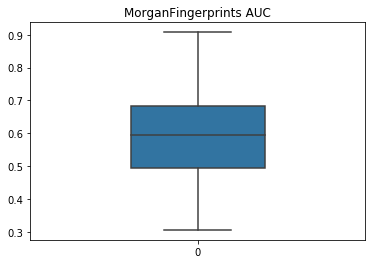

In [172]:
import seaborn as sns

sns_data = pd.DataFrame(data=auc_list, columns=['auc'])
plt.title('MorganFingerprints AUC')
sns.boxplot(data=sns_data['auc'], width=0.4)